In [2]:
import numpy as np
import scipy
import pandas as pd
import pybedtools as pb

# figs
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi']= 150
import seaborn as sns


#import h5py
#import allel

# my libs
import EnrichRLib as erl
import RNA_expression_processing as rn
import Enh_Mut_Manip as emm

# warnings
import warnings
warnings.filterwarnings('ignore')
#warnings.simplefilter("ignore", ResourceWarning)

In [3]:
### == Math functions == 
def log2p1(x):
    return np.log2(x + 1)

In [4]:
# Project settings
from os.path import join 
WORKDIR = '/home/sergio/Res_CIML/TLX3_project'
SCRIPTS = join(WORKDIR,'scripts')
DATADIR = join(WORKDIR,'data')
WGS = join(DATADIR,'tracks/WGS-WES/Germline')
RP = join(DATADIR,'tracks/MARGE/relativeRP/bam_input')



# Data loading

### Regulatory potentials based on H3K27ac -- TLX3-vs-RAG

In [5]:
# Regulatory Potentials
rpt  =  pd.read_table(join(RP,'RAG_TLX_TAP_relativeRP_mm10mm9.txt'))

# -- transform
rpt = rpt.sort_values('lgFC_TLXvsRAG', axis=0, ascending=False)
rpt.drop_duplicates(subset='gene_name', inplace=True)


Ap,Bp = 'TLX_rel_RP','RAG_rel_RP'
cols = ['gene_name', Ap, Bp]

rp = rpt[cols]
rp = rp.set_index(keys=rp.columns[0])


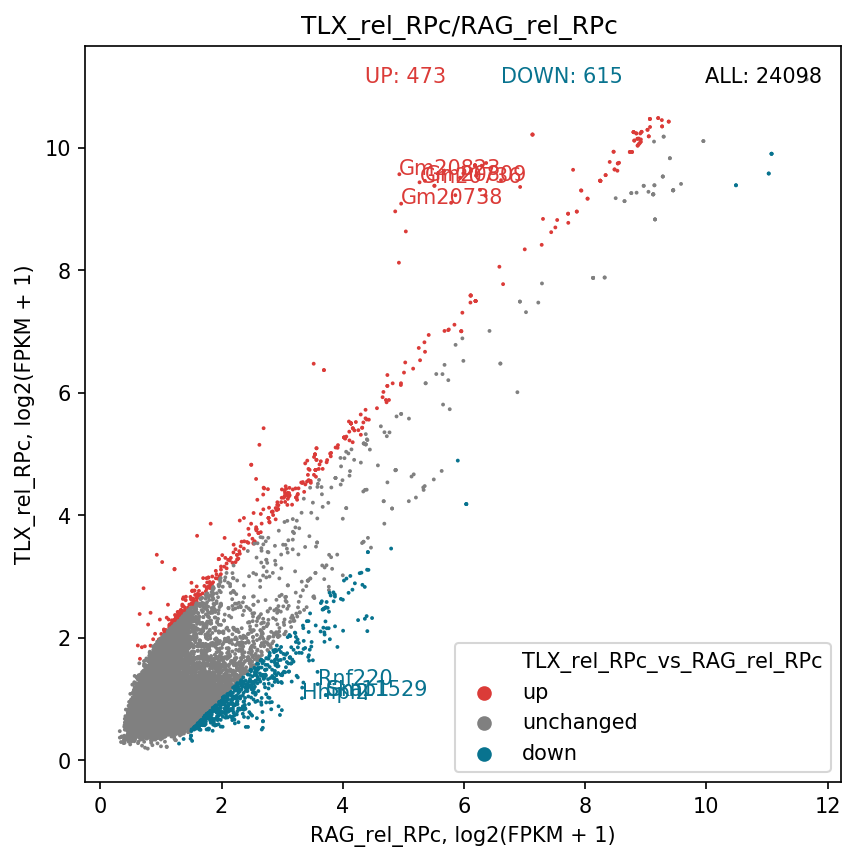

In [6]:
# classes
Ac = Ap+'c'
Bc = Bp+'c'
classe = [Ap+'c', Bp+'c']

up, dn, ax = rn.scatter_n(rp, Ac, Bc, 
                    classes=classe, 
                    n_top=4)

In [7]:
#len(up)

### RNA-expression table TLX3-vs-RAG

In [8]:
## == Expression table TLX3 vs RAG
tbl = pd.read_table(join(DATADIR,'tracks', 'TLX3vsRAG-results_genesNames.txt'), index_col=0)
#tbl = tbl[(tbl.padj < 0.05)].dropna()

cols = ['Gene_name', 'TLX3.1_1','TLX3.1_5','TLX3.1_P','R2.RAG1W.RAG1','RAGS.RAGZ','RAGZ']

tbn = tbl[cols]
expr = tbn.set_index(keys=tbn.columns[0])
#expr.index = expr.index.str.upper()

# RAG: Story ZERO 
# DN_RP(TLX3vsRAG)-->DN_Express(TLX3vsRAG)

![title](im/Prom_Story0R.png)

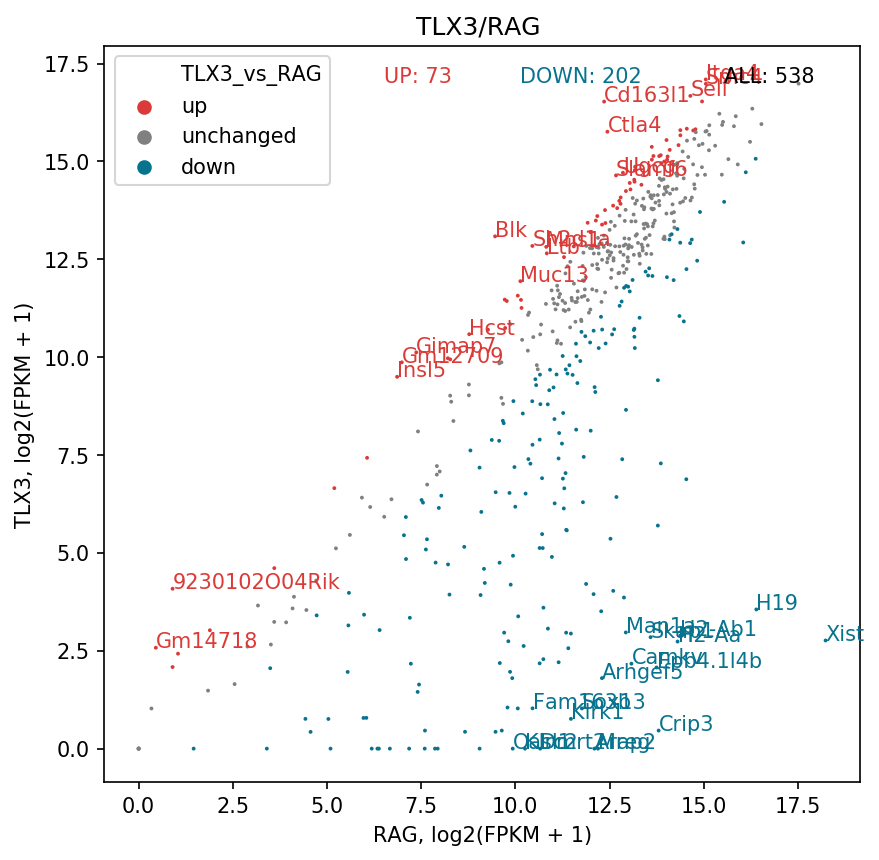

In [9]:
# -- Pheno --
A,B = 'TLX3','RAG'
classes = [A]*3+[B]*3

gl_dn = list(dn.index)

tmp=rn.scatter_n(expr[expr.index.isin(gl_dn)], A, B,classes=classes, n_top=18)

### Enrichment

In [10]:
## Enrichment analysis
# List of gene sets 
gss = [ 
       'GO_Biological_Process_2018',
       'GO_Cellular_Component_2018',
       'GO_Molecular_Function_2018',
       'KEGG_2016',
       'Reactome_2016',
       'Cancer_Cell_Line_Encyclopedia',
       'MSigDB_Computational',
       'MSigDB_Oncogenic_Signatures',
       'NCI-60_Cancer_Cell_Lines',
       'RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO',
       ]

In [12]:
## Two analysis possible

#dn_genes = gl_up # genes with UP H3K27ac TLX3-vs-RAG 

dn_genes = list(tmp[1].index) # ONLY DNregulated genes from genes with UP H3K27ac TLX3-vs-RAG 

DN_genes = [x.upper() for x in dn_genes]

enr = erl.enrich_gs(DN_genes,gss, path_lib='../data/EnrichrLibs')

GO_Biological_Process_2018 1021
GO_Cellular_Component_2018 82
GO_Molecular_Function_2018 233
KEGG_2016 139
Reactome_2016 377
Cancer_Cell_Line_Encyclopedia 757
MSigDB_Computational 330
MSigDB_Oncogenic_Signatures 160
NCI-60_Cancer_Cell_Lines 84
RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO 1197


In [13]:
# Make additional calculation on existing columns for visualization
enr.loc[:,'ass_genes_percnt'] = 100*enr.loc[:,'num_list']/enr.loc[:,'num_term']


# For futher analysis it is convinient to filter terms by p-value
enr_a = enr[(enr['p-Val']<0.05)] #&(enr['ass_genes_percnt']>8)

In [15]:
## Cluster: this calculate and add cluster number column
#enr_a = erl.cluster(FIN_up_genes,enr_a)
cm = 'tab20'
G, enr_c, nt_b =erl.make_graph(DN_genes, 
                                   enr_a, 
                                   kappa=0.4)


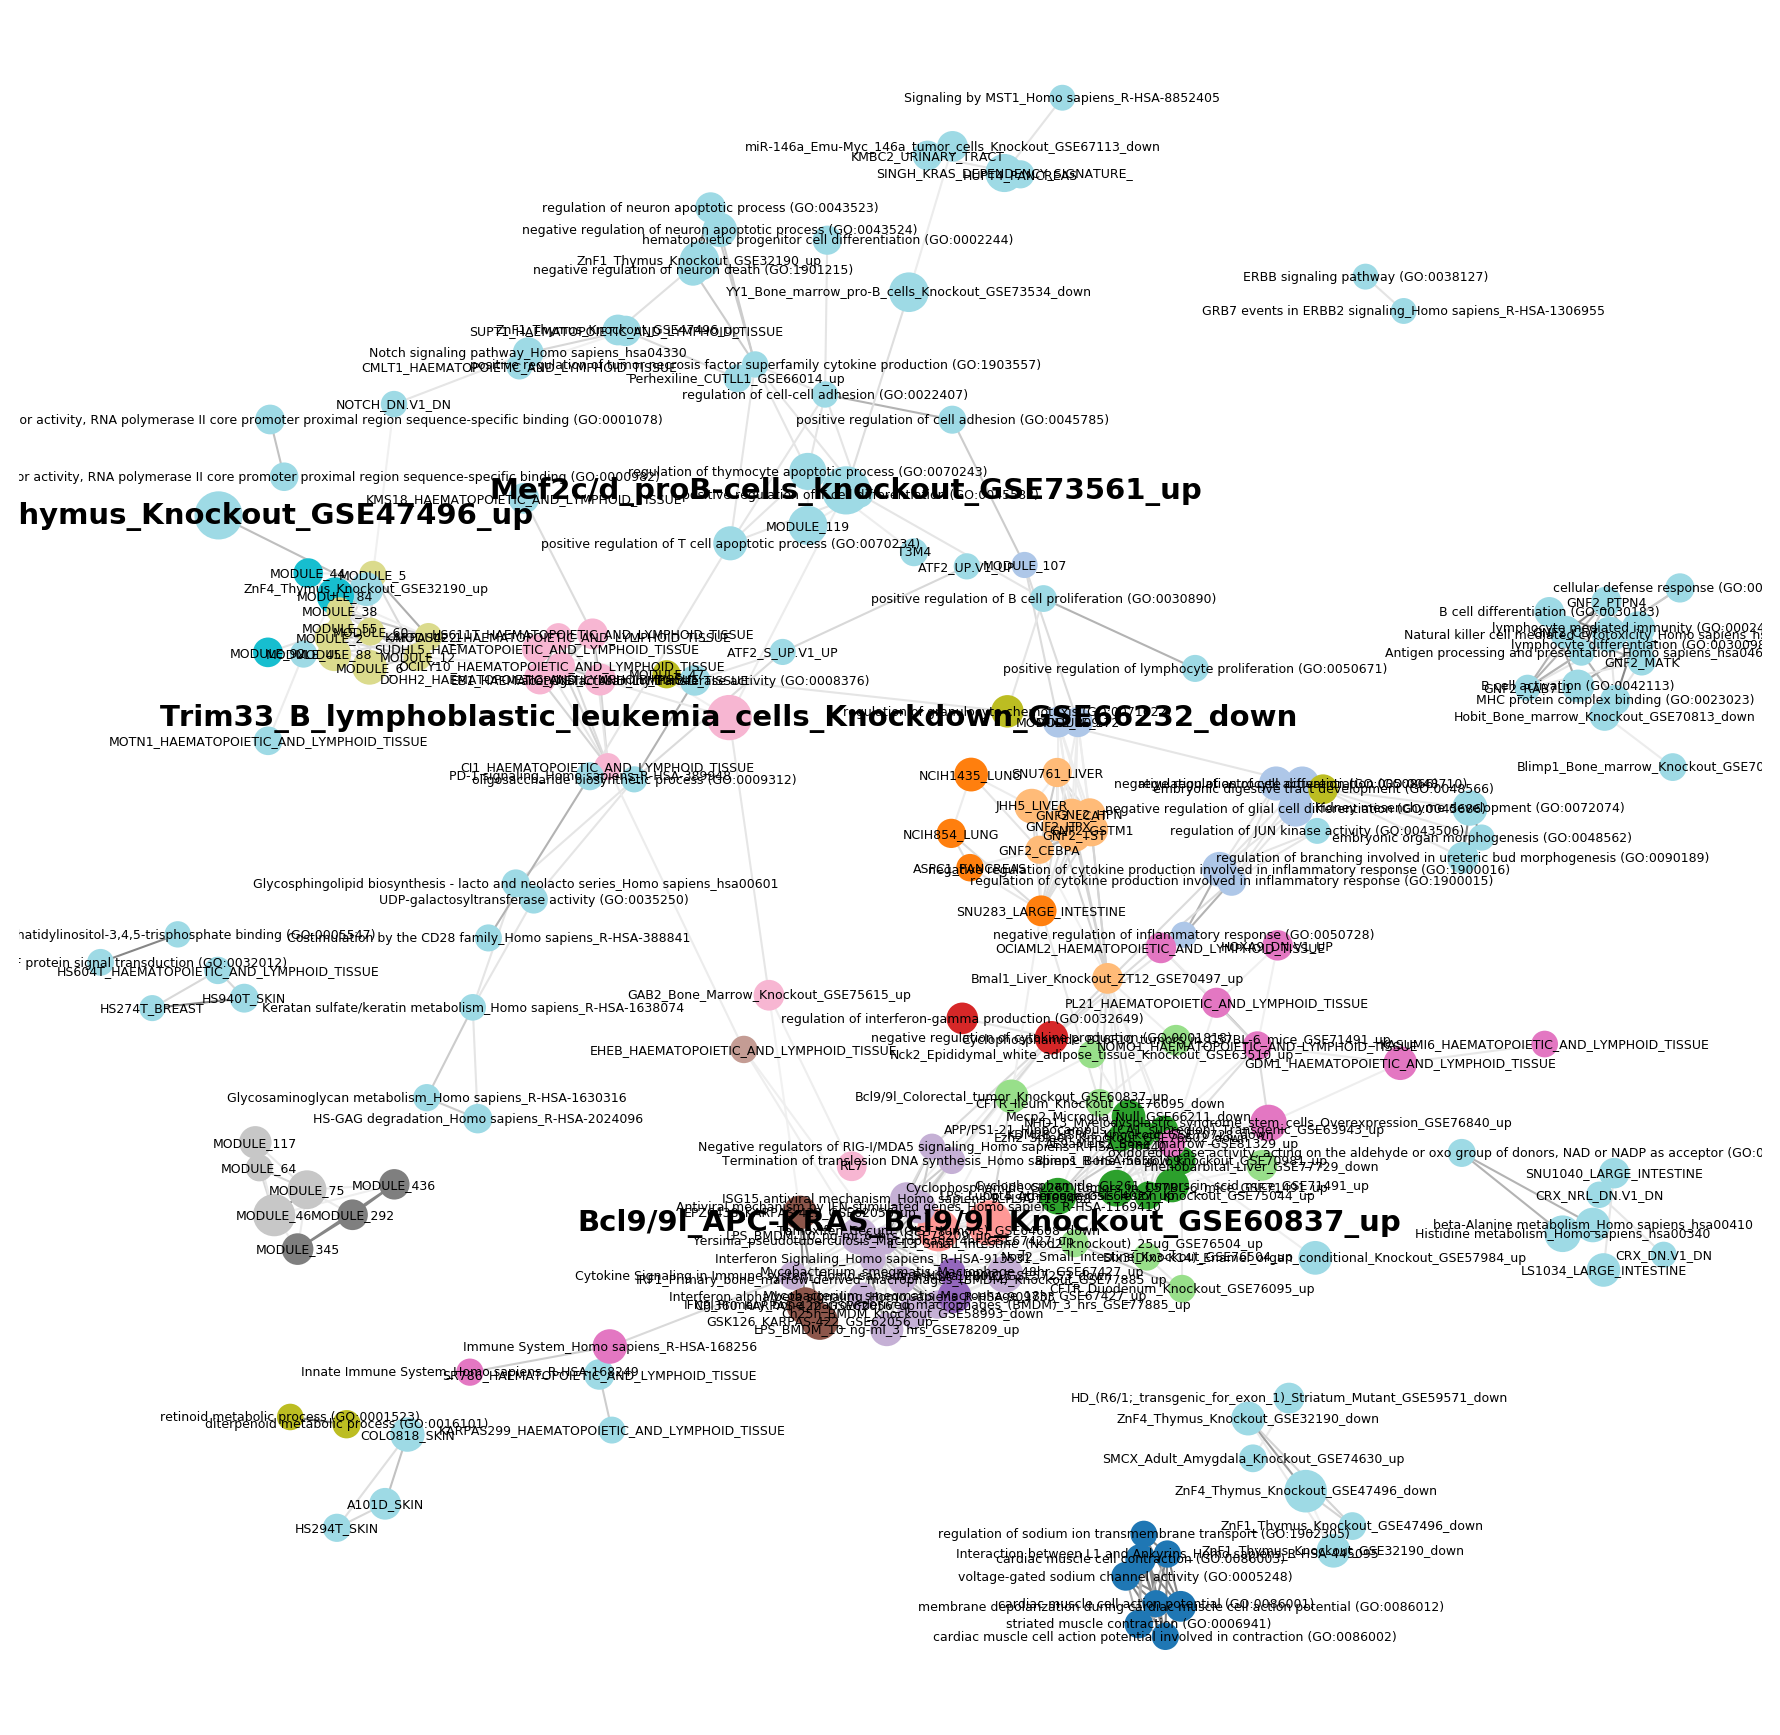

In [17]:
erl.draw_graph(G, 
                spring = 150,
                pval_prcnt=0.8,
                palette=cm)


Text(0.5,1,'DN genes regulated UP H3K27ac (TLX3/RAG) ')

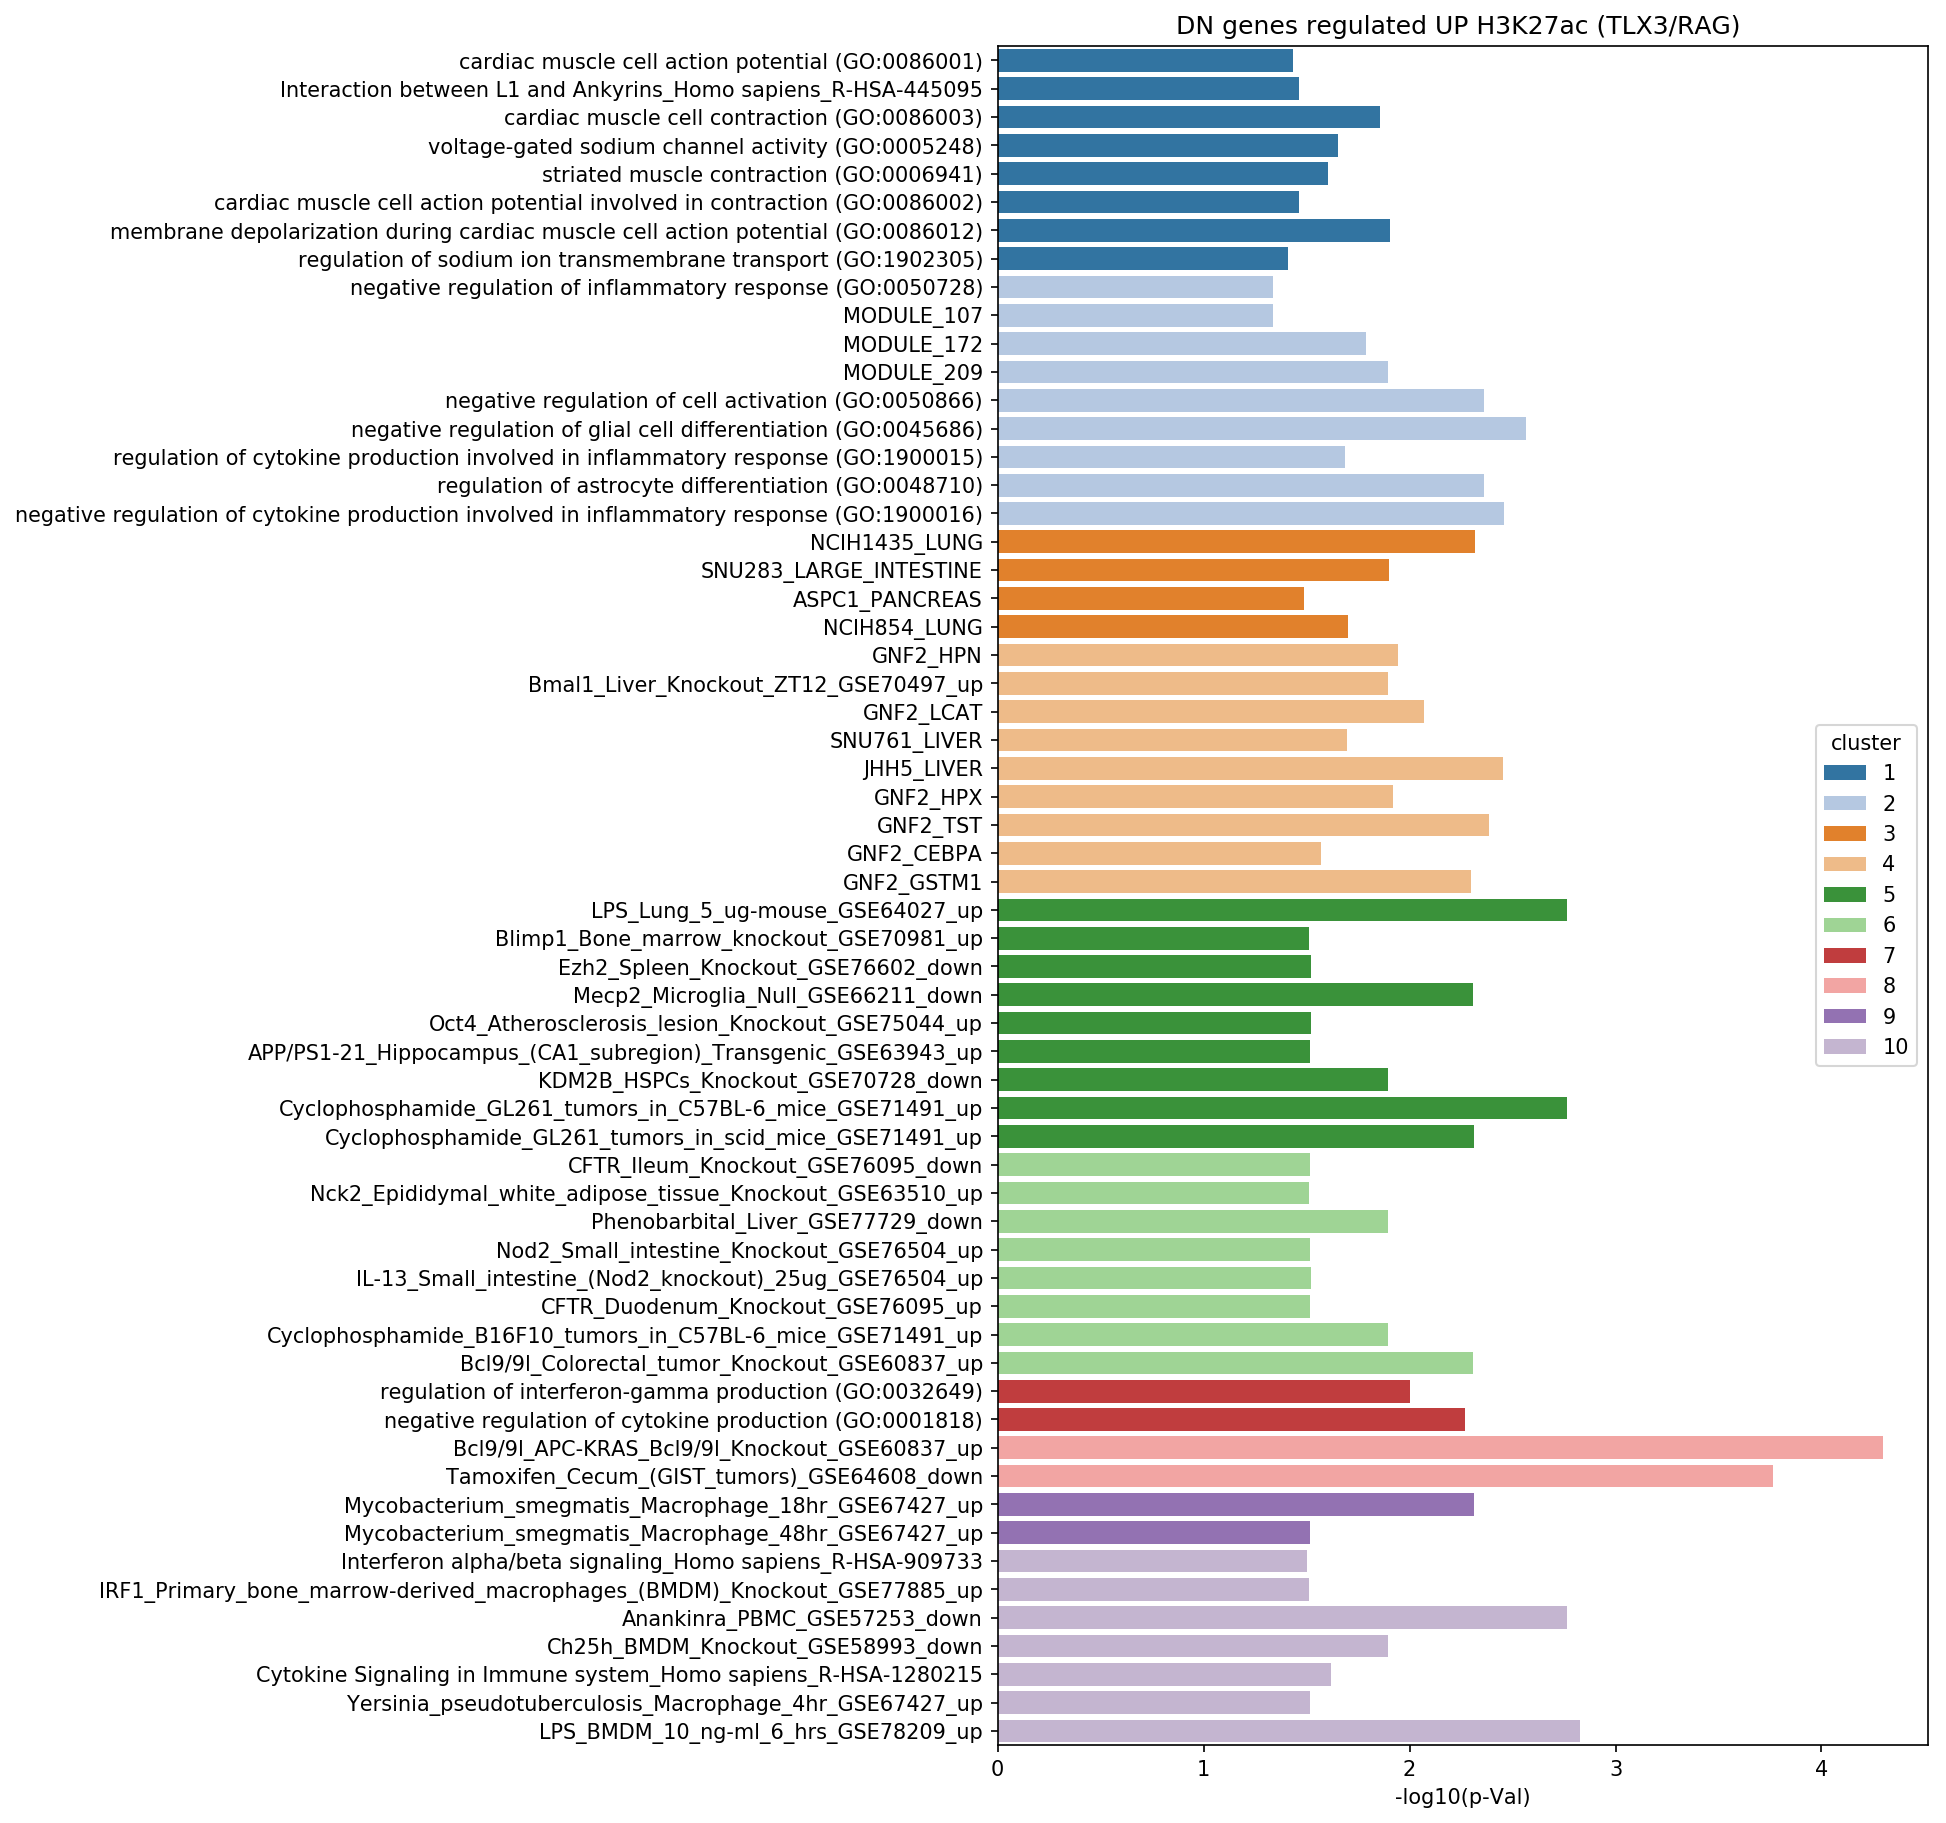

In [21]:
# --- Plot ---
# use consistent discrete palette

enr_c.sort_values('cluster', axis=0, inplace = True)
ds = enr_c.head(60)

f, ax = plt.subplots(figsize=(8, 15))
sns.barplot(y=ds.index,
            x='-log10(p-Val)',
            ax = ax, 
            hue ='cluster',
            dodge=False,
            data = ds,
            palette = cm)
ax.set_title('DN genes regulated UP H3K27ac (TLX3/RAG) ')


# RAG: Story ONE -- TLX3 peaks

![title](im/Prom_Story1R.png)

In [22]:
## Load TLX peaks file
colm9 = ['chr_mm9','start_mm9','end_mm9', 'gene_name']
tlx_peak = pb.BedTool(join(DATADIR,'tracks/TLX3_TLX3_peaks.bed'))
sl = 100
tlx_peak = tlx_peak.slop(b=sl, genome='mm9')

In [23]:
### == DN analysis
tss =  3000

dn_rp = rpt.loc[rpt['gene_name'].isin(list(dn_genes))]
dn_rp = dn_rp[dn_rp['end_mm9']-dn_rp['start_mm9']>0]
dn_rp = pb.BedTool.from_dataframe(dn_rp[colm9])
dn_rp = dn_rp.slop(b=tss, genome='mm9')


dn_rp_tlx = dn_rp+tlx_peak
dn_rp_gene = dn_rp_tlx.to_dataframe()

dnTLX_list =list(dn_rp_gene['name'])
dnTLX_list.sort()

In [24]:
print('Genes with DN RP and upregulated:',list(dn_genes))
print('Genes with DN RP and upregulated and TLX3 peaks:',list(dnTLX_list))

Genes with DN RP and upregulated: ['Gbp8', 'Ldlr', 'B230118H07Rik', 'Adcy6', 'Zfp775', 'Gm16157', 'Tnfsf10', 'Agtrap', 'Bst1', 'Pdcd4', 'Fstl3', 'Fam83a', 'BC049352', 'Agrn', 'Pld4', 'Tnfrsf14', 'Eif4e3', 'Taf1c', 'Adam1b', 'Entpd4', 'Isg15', '2610307P16Rik', 'Bcl7a', 'Mpzl3', 'Rag1', 'Ehd3', 'Gm10684', 'Unc93b1', 'Xk', 'Cd3g', 'Fbxl12', 'Chsy1', 'Aqp11', 'Mir3079', 'Uba7', 'Ilvbl', 'Phgr1', 'Kcna2', 'Ppt2', 'Tbc1d2b', 'F2', '4930594C11Rik', 'Tmem131', 'Hes5', 'Glb1l', 'Engase', 'Gm11747', 'Cd274', 'Lat2', 'AW112010', 'Bfsp2', 'Capn5', 'Gm525', 'Ppp1r9b', '5830432E09Rik', 'Zdhhc14', 'Il18bp', 'Il20ra', 'Usp18', 'Angpt2', 'Slc39a4', 'Wdr78', 'Gm16938', 'Hdac4', 'Carns1', 'Dhrs3', 'Dnmt3b', 'Gm12216', 'Hsdl1', 'Paqr6', 'Repin1', 'Pcmtd1', '2900008C10Rik', 'Prrt1', 'Cblb', 'Il22ra2', 'Frmd6', 'Ypel2', 'Trpv4', 'Gpr152', 'Adam8', 'Aldh1b1', 'B4galt4', 'Gm10390', 'B3galt2', 'Aldh3b1', 'Usp54', 'A930003A15Rik', 'Ptcra', 'Pax9', 'Stat4', 'Angptl7', 'Cd79b', 'Notch3', 'Xkrx', 'Mir1190', 'Pcnx'

# RAG: Story TWO -- TLX3 mutations

![title](im/Prom_Story2R.png)

In [25]:
## == Genome vcf
tlx_gn = pb.BedTool(join(WGS,'TLX3_WGS.vcf.gz'))

tss =  2000
## TSS of active promoters
dn_prom = rpt.loc[rpt['gene_name'].isin(list(gl_dn))]
dn_prom = dn_prom[dn_prom['end_mm9']-dn_prom['start_mm9']==1]
dn_promB = pb.BedTool.from_dataframe(dn_prom[colm9])
dn_promB = dn_promB.slop(b=tss, genome='mm9')


In [26]:
# Count variants in promoters

prom_mut_counts = emm.variants_bed_counts(tlx_gn,dn_promB)
prom_mut_counts = prom_mut_counts.to_dataframe()
prom_mut_counts_srt = prom_mut_counts.sort_values('score', ascending=False)

#prom_mut_counts.head(20)

In [27]:
dn_prom['mut_score'] = prom_mut_counts['score'].values

In [28]:
#dn_prom.head(20)

Text(0.5,1,'Genes for DN promoters with high mutation rate')

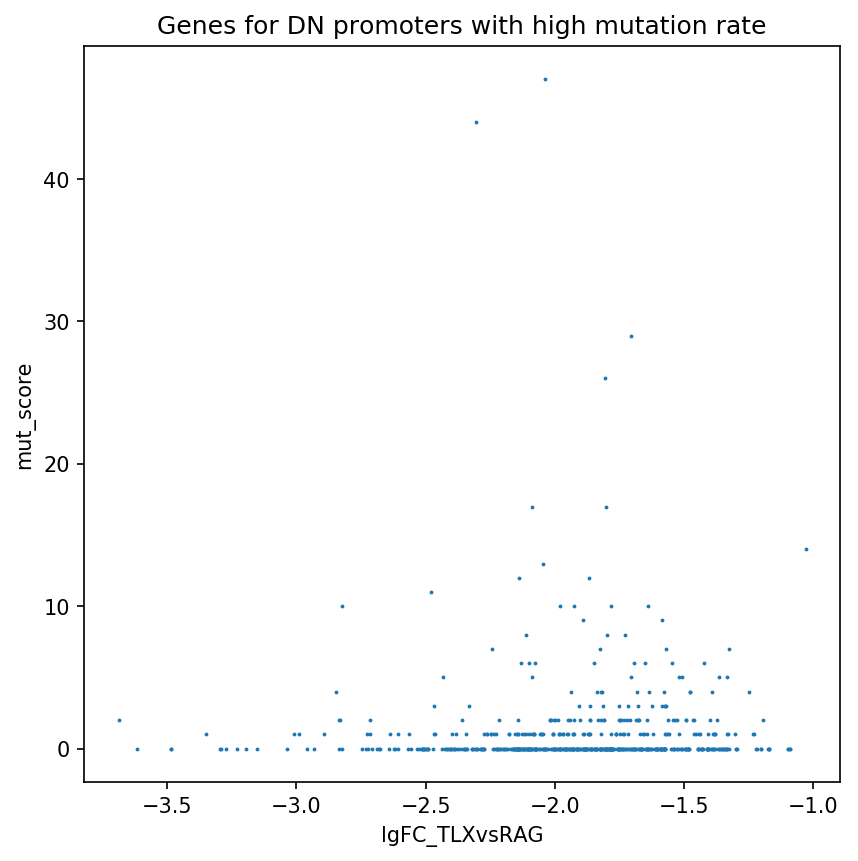

In [29]:
#cpp = {'up':(0.86, 0.23, 0.22), 'unchanged':(0.5,0.5,0.5),'down':(0.03, 0.45, 0.56)}

f1, ax1 = plt.subplots(figsize=(6.5, 6.5))
sns.scatterplot(x = 'lgFC_TLXvsRAG', 
                    y = 'mut_score', 
                    #hue=diff, 
                    data=dn_prom, 
                    ax=ax1, 
 #                   palette=cpp, 
                    linewidth=0, 
                    s=3.4)
ax1.set_title('Genes for DN promoters with high mutation rate')

Text(0.5,1,'Genes for DN promoters with high mutation rate')

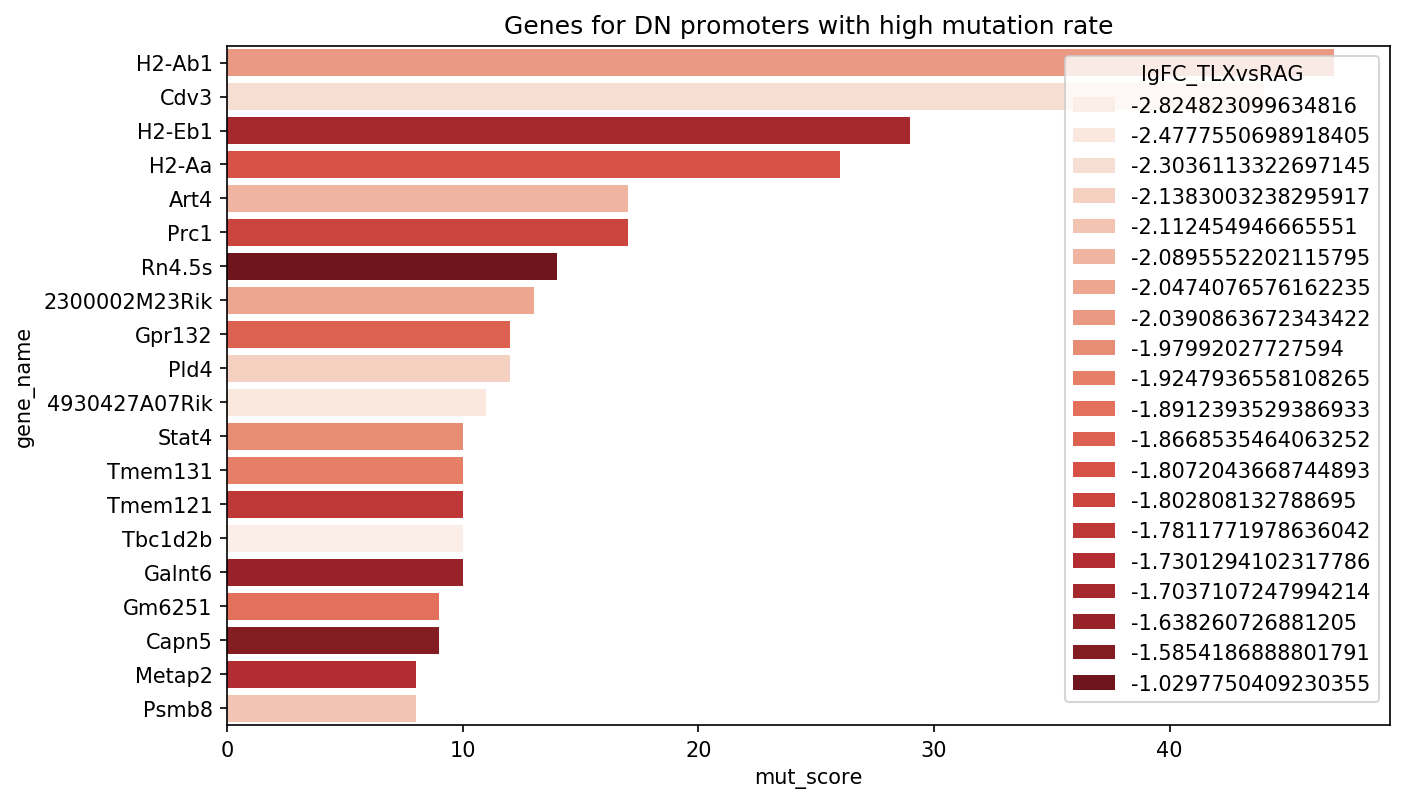

In [31]:
dn_mut_rp = dn_prom.sort_values('mut_score', ascending=False).head(20)#.sort_values('lgFC_TLXvsRAG', ascending=False)

cm = 'Reds'
f, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y='gene_name',
            x='mut_score',
            ax = ax, 
            hue ='lgFC_TLXvsRAG',
            dodge=False,
            data = dn_mut_rp ,
            palette = cm)
ax.set_title('Genes for DN promoters with high mutation rate')

# Motifs around mutations in active promoters

In [32]:
# Motifs models DB
db_f = '/home/sergio/tools/deepbind/db/db.tsv'

db = pd.read_csv(db_f, sep='\t',comment="#", index_col=0)
db = db[db['Labels'].isnull()]
db.drop(columns=['Class','Experiment Details','Model','Cite','Labels','Path','Comment'], inplace=True)

# Select on TFs in mouse
db_tf = db[db['Type']=='TF']
db_tf = db_tf[db_tf['Species']=='Mus musculus']

In [33]:
# Reference genome fasta
from pyfaidx import Fasta
fn = '/home/sergio/media/NAS4/PFlab/TLX3_project/WES-seq/references/mouse_mm9_reference_genome.fa'
fa = Fasta(fn)

In [34]:
# Variant inside active promoters
prom_mut_tlx = emm.bed_variants(tlx_gn,dn_promB)
print('Variants from TLX3 WGS in inactive promoters = ', len(prom_mut_tlx))


# Save only if new analysis done
prom_mut_tlx.saveas(join(WGS,'Promoter_Inactive_TLX3_mut.vcf'))

# Load as table
import allel
prom_mut_tlx_tb = allel.vcf_to_dataframe(join(WGS,'Promoter_Inactive_TLX3_mut.vcf'),fields='*', numbers={'ALT': 4}, transformers=allel.ANNTransformer())

Variants from TLX3 WGS in inactive promoters =  713


In [35]:
# mut_tb = prom_mut_tlx_tb[['CHROM', 'POS', 'REF', 'ALT_1','is_snp']]
# mut_tb = mut_tb.assign(REF_Prot="",
#                        REF_score_ref = np.nan,
#                        REF_score_alt = np.nan,
#                        REF_model = "",
#                        ALT_Prot="", 
#                        ALT_score_ref = np.nan,
#                        ALT_score_alt = np.nan,
#                        ALT_model = "")
# cols = ['CHROM', 'POS', 'REF', 'ALT_1', 'is_snp', 
#         'REF_Prot', 'REF_model', 'REF_score_ref','REF_score_alt', 
#         'ALT_Prot', 'ALT_model', 'ALT_score_ref', 'ALT_score_alt']

# mut_tb = mut_tb[cols]

# pad = 10

# # Cycling
# for i in range(len(mut_tb)):
#     var= mut_tb.loc[i]

#     ln = len(var['REF'])
#     rg = fa[var['CHROM']][int(var['POS'])-pad:int(var['POS'])+ln+pad]

#     pos = var['POS'] - rg.start
#     ref = var['REF'].upper()
#     alt = var['ALT_1'].upper()

#     fs = rg.seq.upper()
#     fm = emm.mut(fs,pos,ref,alt)

#     ### Find best model
#     dv = db_tf.copy()

#     dv['score_ref'] = list(emm.deepbind_list(list(dv.index),fs)['score'])
#     dv['score_alt'] = list(emm.deepbind_list(list(dv.index),fm)['score'])
#     dv_r = dv.sort_values('score_ref',axis=0, ascending=False)
#     dv_a = dv.sort_values('score_alt',axis=0, ascending=False)



#     mut_tb['REF_Prot'].loc[i] = dv_r.iloc[0]['Protein']
#     mut_tb['REF_score_ref'].loc[i] = dv_r.iloc[0]['score_ref']
#     mut_tb['REF_score_alt'].loc[i] = dv_r.iloc[0]['score_alt'] 
#     mut_tb['REF_model'].loc[i] = dv_r.index[0] 


#     mut_tb['ALT_Prot'].loc[i] = dv_a.iloc[0]['Protein'] 
#     mut_tb['ALT_score_ref'].loc[i] = dv_a.iloc[0]['score_ref']
#     mut_tb['ALT_score_alt'].loc[i] = dv_a.iloc[0]['score_alt']
#     mut_tb['ALT_model'].loc[i] = dv_a.index[0] 


# mut_tb.to_csv(join(WGS,'Variants_Promoter_Inactive_Motifs_scores.csv'))

In [36]:
mut_tb = pd.DataFrame.from_csv(join(WGS,'Variants_Promoter_Inactive_Motifs_scores.csv'))


### Select motifs with high score and ones which change TFBS
#### Sort selected motifs by score changes caused by mutation

In [37]:
mut_tb_fltr = mut_tb[(mut_tb['REF_Prot'] != mut_tb['ALT_Prot']) & (mut_tb['REF_score_ref']>2)]
mut_tb_fltr['REF_score_diff'] = mut_tb_fltr['REF_score_ref'] - mut_tb_fltr['REF_score_alt']

mut_tb_fltr_srt = mut_tb_fltr.sort_values('REF_score_diff',axis=0, ascending=False)

In [38]:
mut_tb_fltr_srt.head(10)

CHROM        POS    REF ALT_1  is_snp REF_Prot   REF_model  \
432  chr18   36355569  AGGGG     A   False   Znf740  D00083.001   
52   chr10   19926425      G     T    True   Znf740  D00083.001   
436  chr19   41102015      G     T    True     Sox6  D00039.001   
513   chr6  108780627      G     T    True     Sox6  D00039.001   
304  chr17   34401355      C     T    True   Znf740  D00083.001   
21    chr1   36997030      C     T    True      Sp1  D00017.001   
119  chr12  113999846      G     A    True      Sp1  D00017.001   
474   chr5  105568339      C     G    True  Zkscan5  D00082.001   
302  chr17   34401018      A     T    True    Foxg1  D00062.001   
301  chr17   34401017      A     G    True    Foxg1  D00062.001   

     REF_score_ref  REF_score_alt                 ALT_Prot   ALT_model  \
432      18.574577       3.199451                      Sp1  D00017.001   
52       17.949394       3.284152                     Egr3  D00058.001   
436      10.532830       0.651845                   Ahctf1  D00053.001   
513      10.363365       0.707858                    Foxc2  D00061.001   
304      15.474932       5.942666                   Zfp202  D00047.001   
21        8.008424      -0.155382                    Foxg1  D00062.001   
119       8.151410       0.069650  chr15-10391820-10399583  D00056.001   
474       8.539598       0.582543                    Nr5a2  D00069.001   
302       7.781857       0.132290                   Zfp300  D00079.001   
301       7.063983      -0.548392                     Egr3  D00058.004   

     ALT_score_ref  ALT_score_alt  REF_score_diff  
432       7.250298       7.976914       15.375126  
52        5.623361       6.486984       14.665242  
436       3.559591       4.129058        9.880985  
513       3.760597       3.655294        9.655507  
304       7.305537       6.302427        9.532266  
21        0.952545       1.493008        8.163806  
119       3.620193       5.740448        8.081760  
474       0.109051       5.806129        7.957055  
302       0.355134       0.698954        7.649567  
301       0.588294       0.883758        7.612375

## Find promoters with TFS changes and associated genes

In [39]:
# Back to bed and enhancers list
mut_bd = mut_tb_fltr_srt[mut_tb_fltr_srt['REF_score_diff']>1][['CHROM','POS','REF','REF_Prot']]


mut_bd['POS_end'] = mut_bd['POS']+mut_bd['REF'].apply(len)
mut_bd = mut_bd[['CHROM','POS','POS_end', 'REF_Prot']]

mut_tf = pb.BedTool.from_dataframe(mut_bd).sort()


In [ ]:
#len(up_promB)

In [40]:
mut_tf_prom = dn_promB.intersect(mut_tf,wb=True).to_dataframe()
mut_tf_prom.drop(columns=['score','strand','thickStart'], inplace=True)
mut_tf_prom.rename(columns={'thickEnd':'protein'}, inplace=True)

In [41]:
mut_tf_prom_dd = mut_tf_prom.drop_duplicates()

In [42]:
print('Genes with promoters with TFBS cahnges:\n', list(mut_tf_prom_dd['name'].unique()))

Genes with promoters with TFBS cahnges:
 ['Mir6973a', 'Ltb', '2010109I03Rik', 'Mns1', 'C330011F03Rik', 'Gbp9', '9230102O04Rik', '1700097N02Rik', 'Dnah8', 'Gbp4', 'Gm16576', 'Sun2', 'Capn5', 'Vmn1r1', 'Isl1', 'Usp7', 'Klre1', 'Gbp8', 'H2-Eb1', 'Metap2', 'Mir7218', 'Ppm1h', 'Mir8104', 'Itgal', 'Tmem121', 'Nhp2l1', 'Prc1', 'H2-Aa', 'Notch3', 'Psmb9', 'Tap1', 'Uhrf1', 'Klrk1', 'Unc93b1', 'Arrdc5', 'Bfsp2', 'Gpr132', 'Gm6251', 'Tmem131', 'Edem1', 'Klrd1', 'Stat4', 'H2-Ab1', '2300002M23Rik', 'Il18bp', 'Ephx3', 'Uvrag', 'Tmem204', 'Psmb8', 'Mreg', 'Pld4', 'Tshz2', 'A930003A15Rik', 'Nrg2', 'Cdv3', 'Gm590', 'Dntt', 'Tbc1d2b', 'Aqp11', 'Mycn', 'Rnf220']


In [43]:
genes_mut_tf_prom = [x.upper() for x in list(mut_tf_prom_dd['name'].unique())]

enr_genes_mut_tf_prom = erl.enrich_gs(genes_mut_tf_prom,gss, path_lib='../data/EnrichrLibs')

GO_Biological_Process_2018 342
GO_Cellular_Component_2018 45
GO_Molecular_Function_2018 94
KEGG_2016 41
Reactome_2016 261
Cancer_Cell_Line_Encyclopedia 354
MSigDB_Computational 187
MSigDB_Oncogenic_Signatures 68
NCI-60_Cancer_Cell_Lines 41
RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO 909


In [44]:
# Make additional calculation on existing columns for visualization
enr_genes_mut_tf_prom.loc[:,'ass_genes_percnt'] = 100*enr_genes_mut_tf_prom.loc[:,'num_list']/enr_genes_mut_tf_prom.loc[:,'num_term']


# For futher analysis it is convinient to filter terms by p-value
enr_genes_mut_tf_prom = enr_genes_mut_tf_prom[(enr_genes_mut_tf_prom['p-Val']<0.05)&(enr_genes_mut_tf_prom['ass_genes_percnt']>5)]

## Cluster: this calculate and add cluster number column
#enr_genes_mut_tf_enh = erl.cluster(genes_mut_tf_enh,enr_genes_mut_tf_enh)
G, enr_genes_mut_tf_prom_c, nt_b =erl.make_graph(genes_mut_tf_prom, 
                                                 enr_genes_mut_tf_prom,
                                                 kappa=0.4)




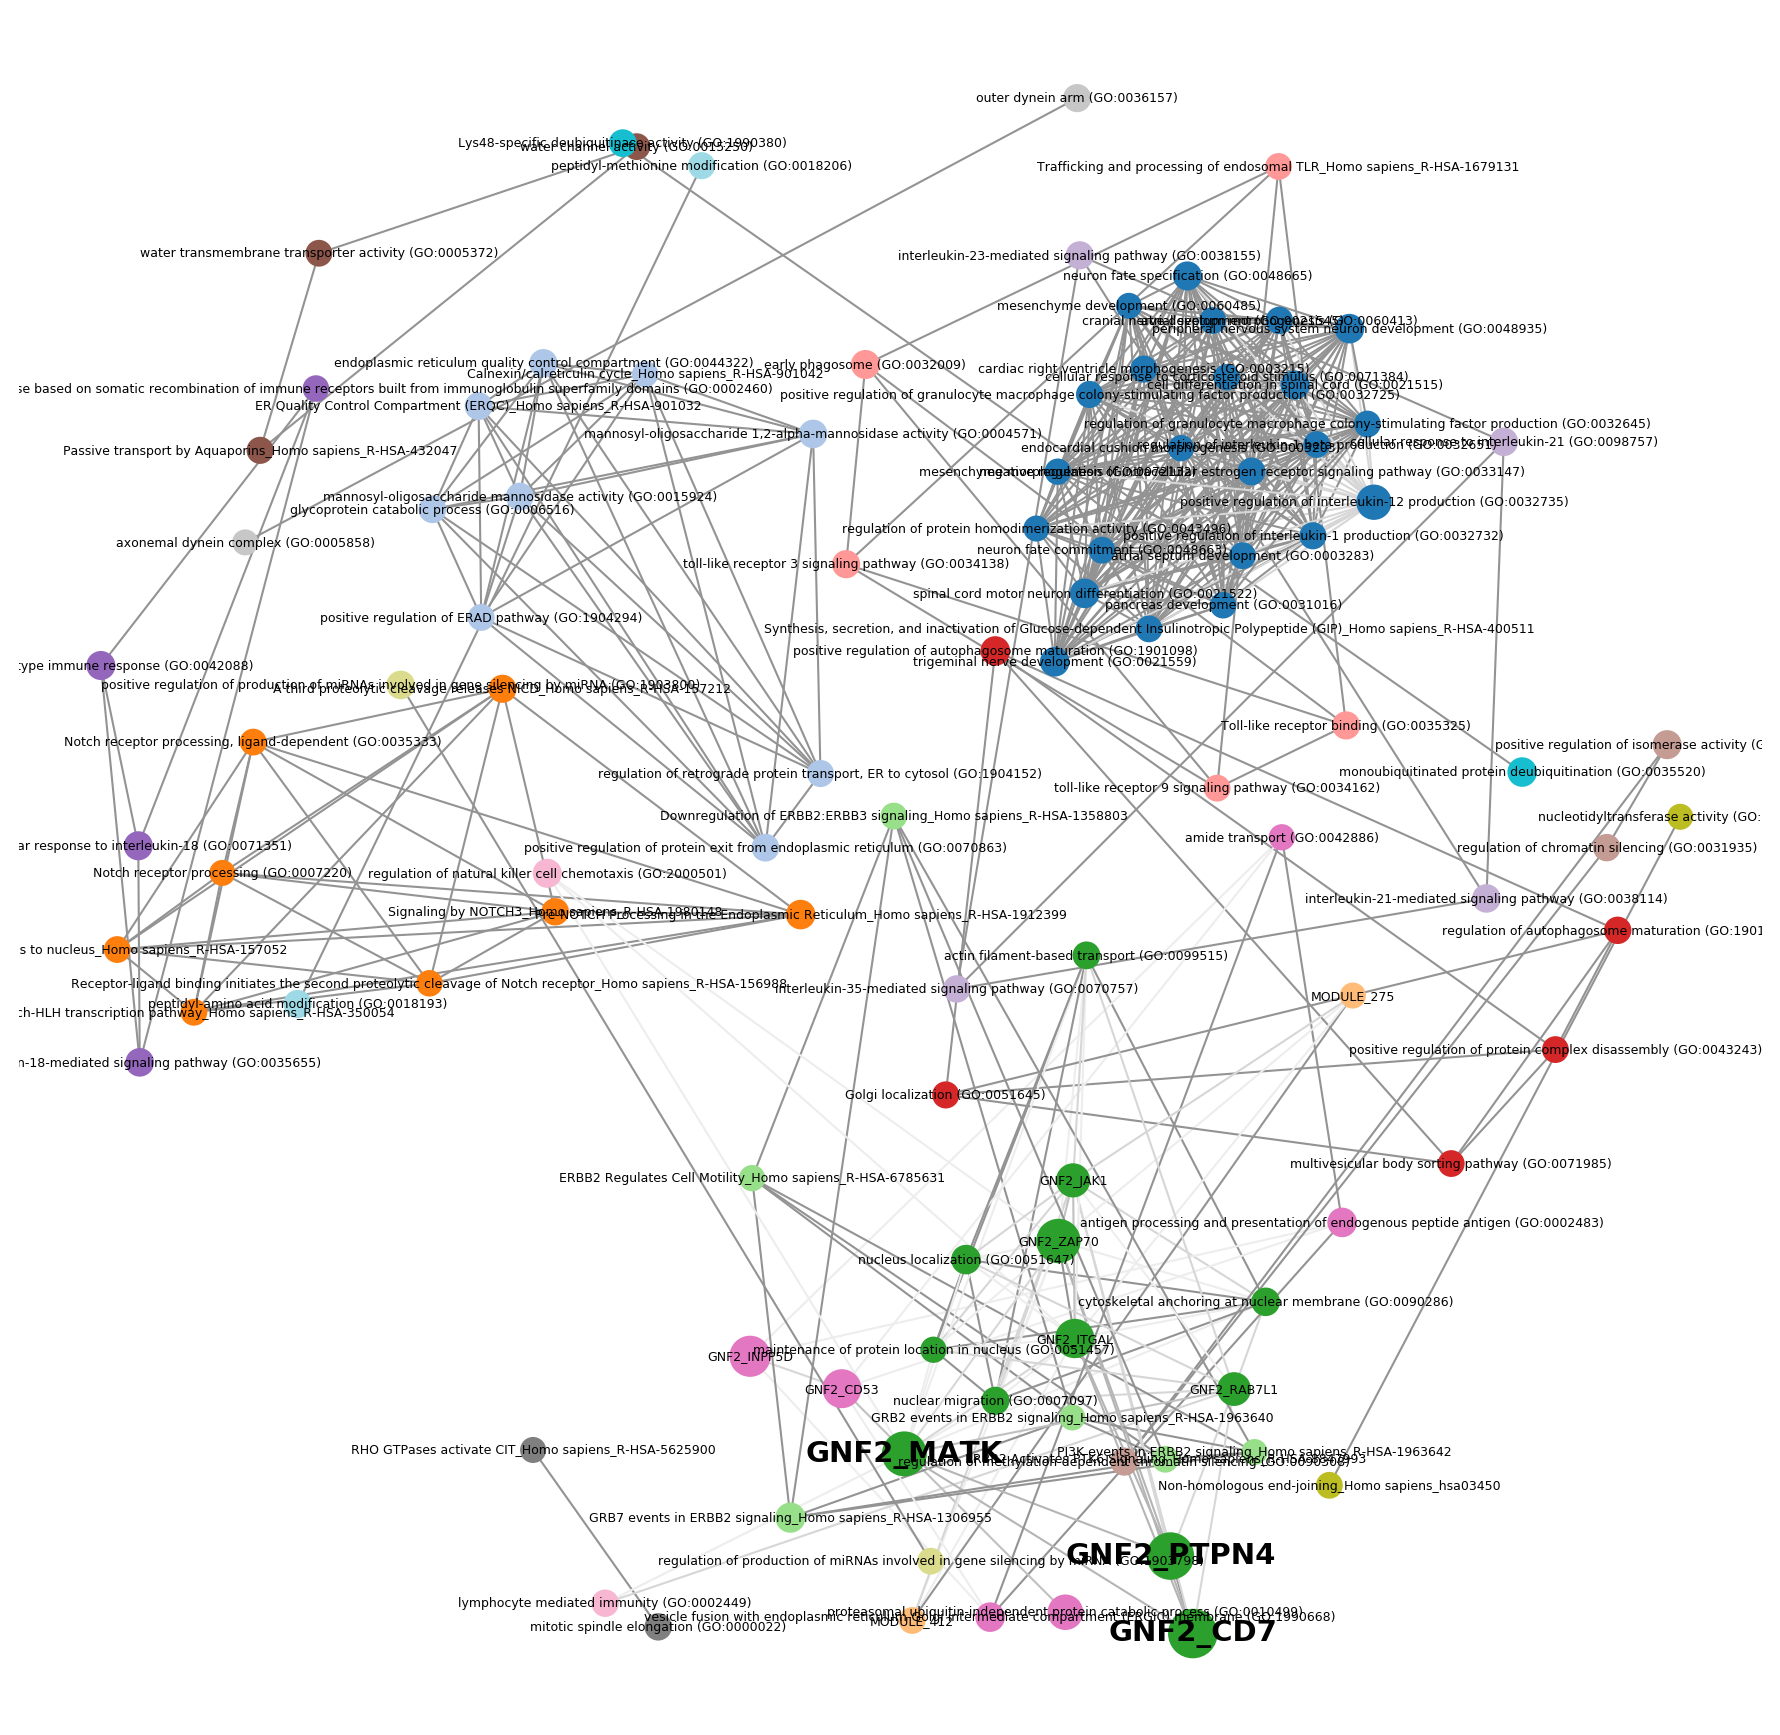

In [55]:
erl.draw_graph(G, spring=1.5)

Text(0.5,1,'Genes for UP enhancers with TF mutations')

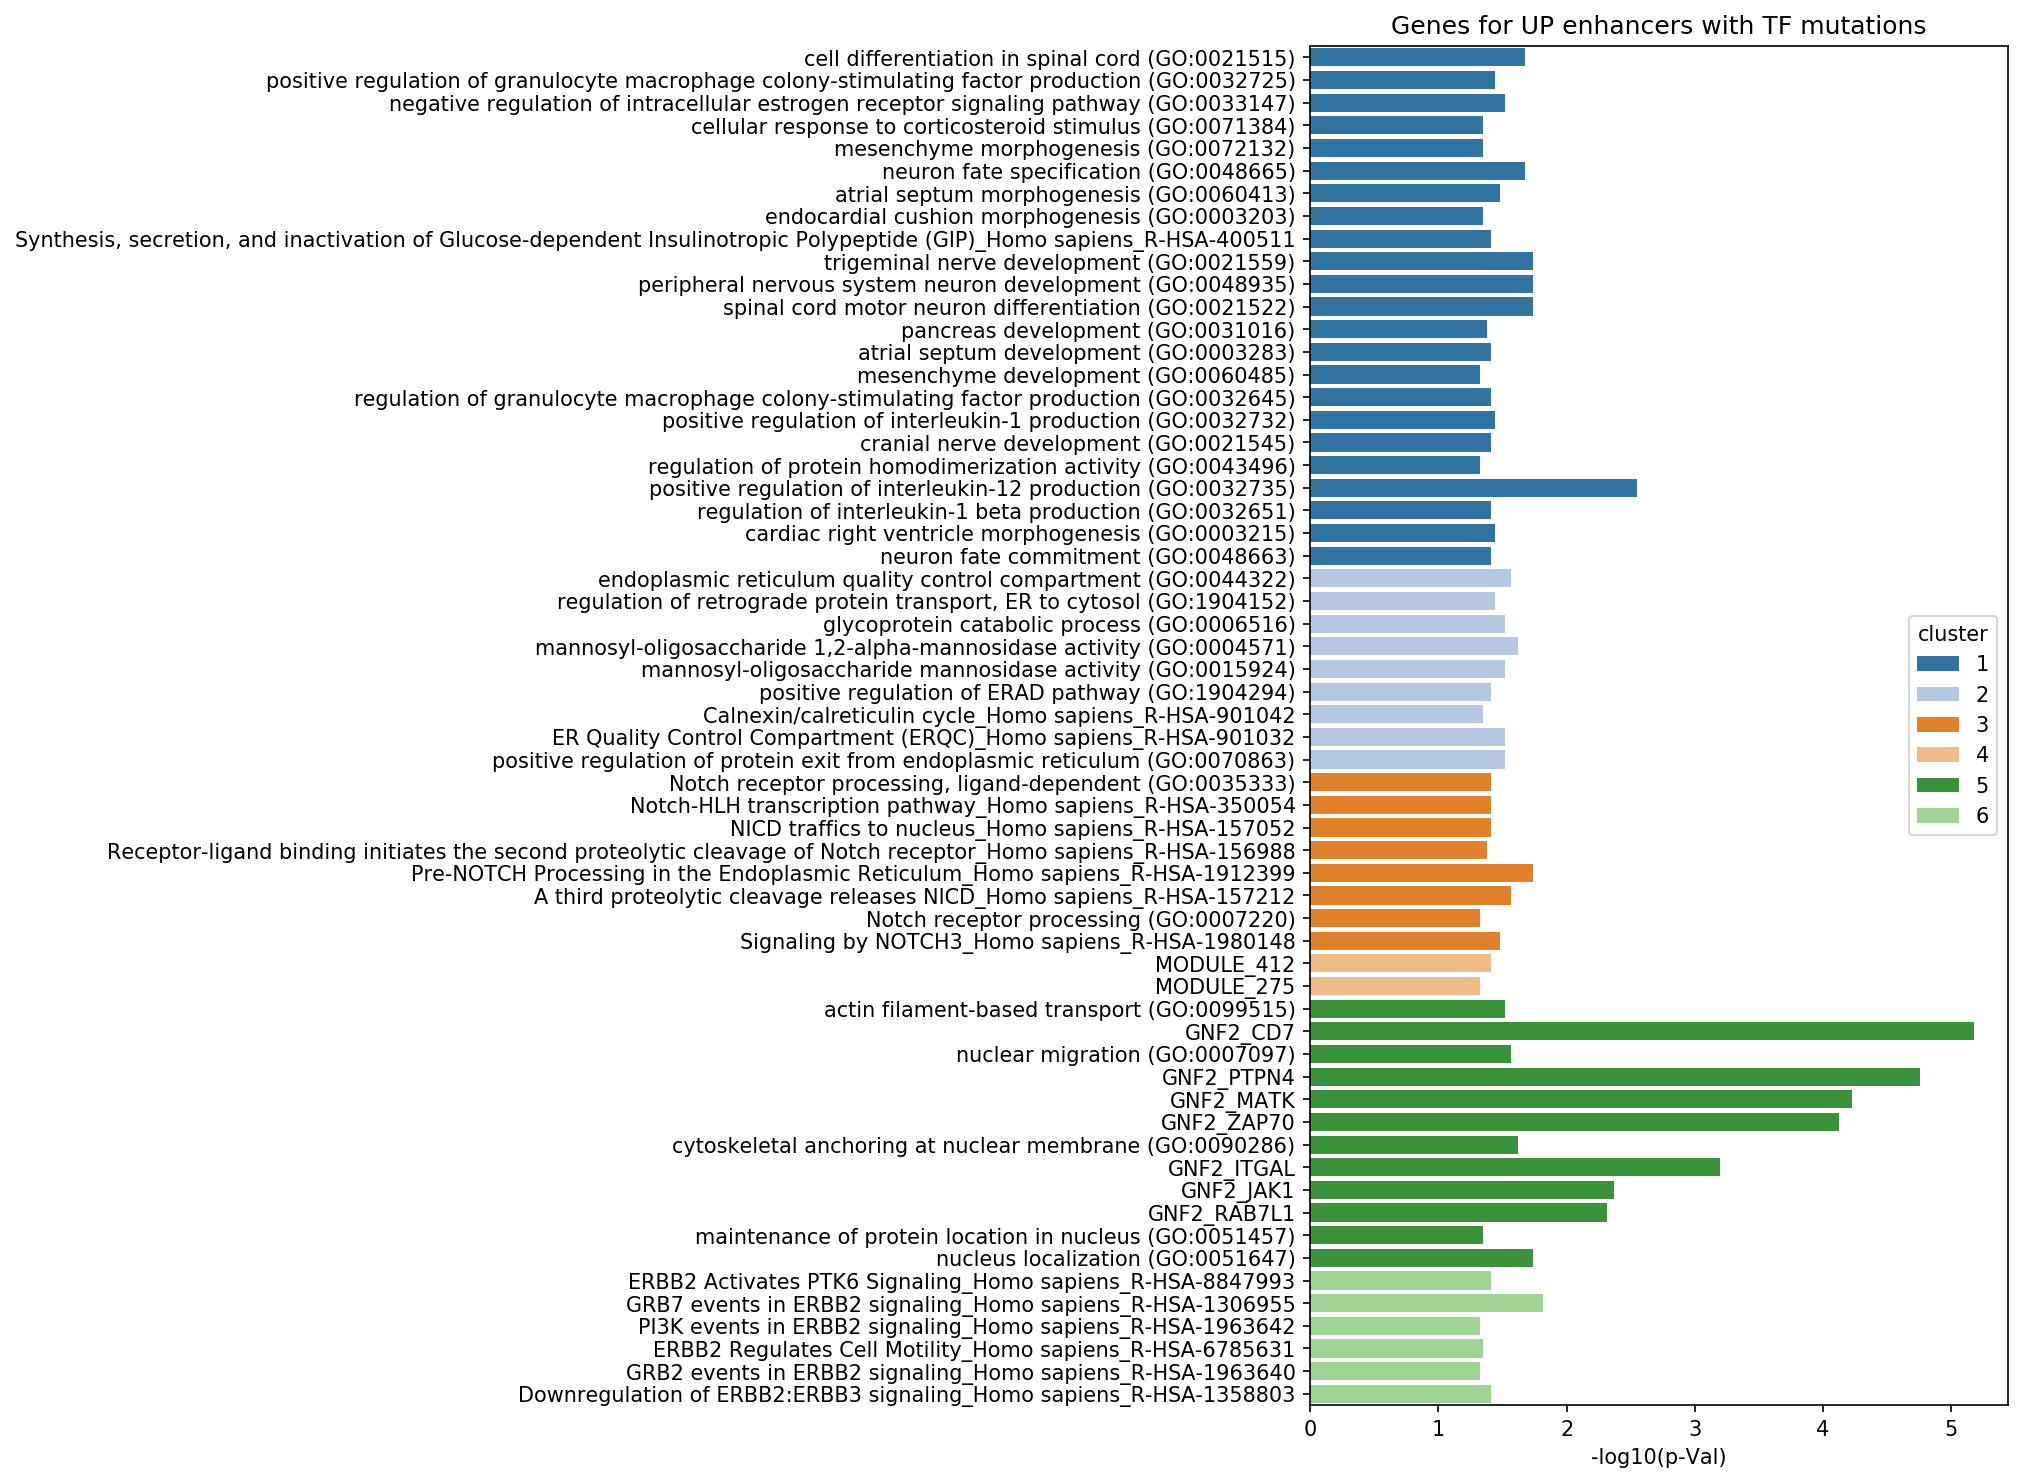

In [52]:
enr_genes_mut_tf_prom_c.sort_values('cluster', axis=0, inplace = True)
# --- Plot ---
# use consistent discrete palette
cm = 'tab20'

ds = enr_genes_mut_tf_prom_c.head(60)

f, ax = plt.subplots(figsize=(6, 12))
sns.barplot(y=ds.index,
            x='-log10(p-Val)',
            ax = ax, 
            hue ='cluster',
            dodge=False,
            data = ds,
            palette = cm)
ax.set_title('Genes for UP enhancers with TF mutations')